
## Máster Universitario en Ciencia de Datos
### Métodos Avanzados en Aprendizaje Automático


In [13]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBClassifier_Sklearn
import pandas as pd

from utils import plotData, plotModel, createDataSet, createRegressionDataSet, plotRegressionModel, plotRegressionData

In [14]:
from sklearn.tree import DecisionTreeRegressor

""" Solo se va a implementar para regresión y para clasificación 
    binaria con clases igual a -1 y +1
"""

class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return np.mean(y)

    def residuals(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return y - F

    def paso_newton_hoja(_, y, residuals, leaf_value):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado al arbol regresor ht
           Además recibe el valor actual de salida de la hoja (valor)
              
            Debe devolver el valor actualizado
        """
        return leaf_value
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5 * (y - F)**2
    
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        bar_y = np.mean(y)
        return 0.5 * ( np.log(1 + bar_y) - np.log(1 - bar_y) ) 

    def residuals(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return (2 * y) / (1 + np.exp(2* y *F))

    def paso_newton_hoja(_, y, residuals, leaf_value):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recibe el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        denominator = np.sum( np.abs(residuals) * (2 - np.abs(residuals)) )
        if np.abs(denominator) < 1e-50:
            return 0.0
        return np.sum(residuals) / denominator

    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1 + np.exp(-2.0 * y * F))

In [15]:
class GradientBoosting(BaseEstimator):
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
        self._F0          = 0
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        self._estimators  = []
        self._F0 = self.loss.F0(X, y)
        F_previous = np.full(X.shape[0], self._F0)

        for i in range(self.n_estimators):
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            # Compute pseudo residuals
            residuals = self.loss.residuals(y, F_previous)

            # Fit a regressor on the dataset (MSE)
            tree = DecisionTreeRegressor(max_depth = self.depth)
            tree.fit(X, residuals)
            
            # Compute N-R step
            self.paso_newton_general(tree, X, y, residuals)
            self._estimators.append(tree)
            
            # Update model
            F_previous = F_previous + self.eta * tree.predict(X)

        return self
            
    def paso_newton_general(self, tree, X, y, residuals):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuals[ii],
                                                              tree.value[leaf,0,0])

    def raw_predict(self, X, n_estimators=None):
        """ Combinamos los valores de pesos y hs para obtener la 'salida', y:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable """

        if n_estimators is None:
            n_estimators = self.n_estimators
        else:
            if n_estimators > self.n_estimators:
                raise ValueError(
                    'n_estimators can\'t be greater than the number of estimators used in prediction')
            
        predictions = np.array([tree.predict(X) for tree in self._estimators[:n_estimators]])
        return self.eta * predictions.sum(axis=0) + self._F0

    @abstractmethod
    def score(self, X, y):
        pass

    @abstractmethod
    def predict(self, X):
        pass

    @abstractmethod
    def predict_with_fewer_estimators(self, X, n_estimators):
        pass

In [16]:
class GradientBoostingRegressor(GradientBoosting):
    def __init__(self, n_estimators=101, eta=0.1, depth=3):
        super().__init__(n_estimators=n_estimators, loss=SquaredErrorLoss(), eta=eta, depth=depth)

    def predict(self, X):
        return self.raw_predict(X)

    def predict_with_fewer_estimators(self, X, n_estimators):
        return self.raw_predict(X, n_estimators)

    def score(self, y, predictions):
        """ Devuelve el MSE entre las predicciones y las etiquetas. """
        return np.mean((y - predictions) ** 2)

class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=101, eta=0.1, depth=3):
        super().__init__(n_estimators=n_estimators, loss=LogLoss(), eta=eta, depth=depth)

    def raw_predictions_to_classes(self, raw_predictions):
        classes = np.sign(raw_predictions)
        classes[classes == 0] = 1
        return classes

    def predict(self, X):
        raw_predictions = self.raw_predict(X)
        return self.raw_predictions_to_classes(raw_predictions)

    def predict_with_fewer_estimators(self, X, n_estimators):
        raw_predictions = self.raw_predict(X, n_estimators)
        return self.raw_predictions_to_classes(raw_predictions)
    
    def score(self, y, predictions):
        """ Devuelve el accuracy entre las predicciones y las etiquetas. """
        return np.mean(predictions == y)

# Pruebas

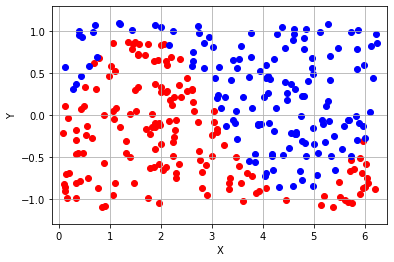

In [17]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
x1test, x2test, ytest = createDataSet(n*10, model, ymargin, noise)
Xtrain = np.concatenate((x1, x2), axis = 1)
Xtest = np.concatenate((x1test, x2test), axis = 1)
ytrain[ytrain == 0] = -1
ytest[ytest == 0] = -1
plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})

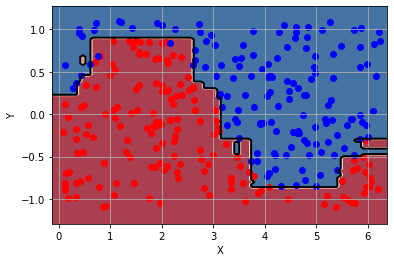

In [18]:
gb_regressor = GradientBoostingClassifier()
gb_regressor.fit(Xtrain, ytrain)
plotModel(x1 ,x2, ytrain, gb_regressor)

In [19]:
from sklearn.preprocessing import LabelBinarizer

# Magic
fP = 'datos/magic04.csv'
dfP = pd.read_csv(fP, sep=',')

X_tr, X_ts, y_tr, y_ts = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], 
                                          test_size=0.8, random_state=1)
lb   = LabelBinarizer(pos_label = 1, neg_label = -1)
y_tr = lb.fit_transform(y_tr).ravel()
y_ts = lb.transform(y_ts).ravel()

gb = GradientBoostingClassifier()

gb.fit(X_tr, y_tr)
print("Accuracy in Magic04=", gb.score(y_ts, gb.predict(X_ts)))

Accuracy in Magic04= 0.8621188222923238


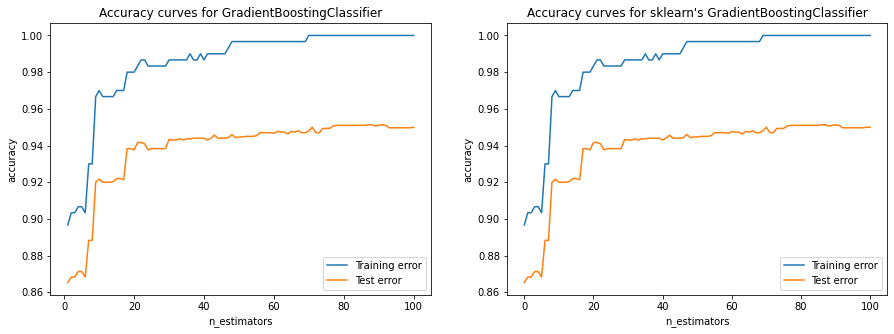

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

gb = GradientBoostingClassifier()
gb.fit(Xtrain, ytrain)
acc_train = [ gb.score(ytrain, gb.predict_with_fewer_estimators(Xtrain, n_est))
                for n_est in range(1, gb.n_estimators)]
acc_test = [ gb.score(ytest, gb.predict_with_fewer_estimators(Xtest, n_est))
                for n_est in range(1, gb.n_estimators)]
xs = np.arange(1, gb.n_estimators)
axs[0].plot(xs, acc_train, label = "Training error")
axs[0].plot(xs, acc_test, label = "Test error")
axs[0].legend()
axs[0].set_title("Accuracy curves for GradientBoostingClassifier")
axs[0].set_xlabel("n_estimators")
axs[0].set_ylabel("accuracy")

gb_sklearn = GBClassifier_Sklearn(n_estimators=101)
gb_sklearn.fit(Xtrain, ytrain)
acc_train_sk = [np.mean(predictions == ytrain) for predictions in gb_sklearn.staged_predict(Xtrain)]
acc_test_sk = [np.mean(predictions == ytest) for predictions in gb_sklearn.staged_predict(Xtest)]
xs = np.arange(gb.n_estimators)
axs[1].plot(xs, acc_train_sk, label = "Training error")
axs[1].plot(xs, acc_test_sk, label = "Test error")
axs[1].legend()
axs[1].set_title("Accuracy curves for sklearn's GradientBoostingClassifier")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("accuracy")

plt.show()

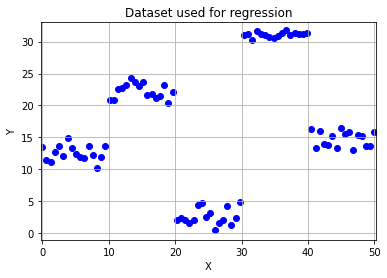

In [21]:
# Problem data for regression:
np.random.seed(123)
n = 100
Xtrain, ytrain, Xtest, ytest = createRegressionDataSet(n)
plotRegressionData(Xtrain, ytrain, 'Dataset used for regression')

In [22]:
gb = GradientBoostingRegressor()
gb.fit(Xtrain, ytrain)
print('Score (MSE) in training: {}'.format(gb.score(ytrain, gb.predict(Xtrain))))
print('Score (MSE) in test: {}'.format(gb.score(ytest, gb.predict(Xtest))))

Score (MSE) in training: 0.1825428950959412
Score (MSE) in test: 2.0763633032828164


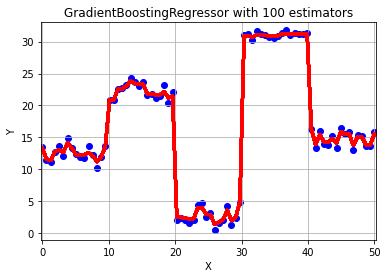

In [23]:
gb = GradientBoostingRegressor()
gb.fit(Xtrain, ytrain)
plotRegressionModel(Xtrain, ytrain, gb, "GradientBoostingRegressor with 100 estimators")

#### Visualizar el conjunto
Se entrena un random forest con 3 árboles para visualizar la frontera de decisión cuándo se combinan en el conjunto de clasificadores y cada árbol por separado
<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ejecuta el código de con noise=0 y n_estimators=3 y estudia el resultado de los árboles por separado y en conjunto. En concreto analiza:
<ul>
<li> (1) Las fronteras de decisión de los árboles individuales con respecto a la frontera de los árboles combinados.</li>
<li> (2) ¿Por qué son tan diferentes las fronteras de los árboles individuales? Para responder piensa cómo se han creado esos árboles</li>
<li> (3) Mira los errores en test de los árboles individuales y del conjunto ¿Cuál es que mejor error obtine? ¿Por qué?</li>
</ul>
</div>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
    <b>Nota: No es necesario entregar ninguna de estas cuestiones</b> 
<ul>
<li> (1) ...</li>
<li> (2) ...</li>
<li> (3) ...</li>
</ul>
</div>

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ahora ejecuta las dos celdas siguientes modificando el nivel de ruiso (noise=0.0 y noise=0.3). A continuación prueba con n_estimators igual a 3, 31 y 301 para cada uno de los niveles de ruido y rellena el acierto en test y train en la siguiente tabla:<br/></div>
<br>

<div style="background-color:#EEEEAA;padding:20px;border:solid;">

(4) Respuestas:

| Acierto train/test | n_estimators=3 | n_estimators=31 | n_estimators=301 |
|--------------------|----------------|-----------------|------------------|
| noise=0            |                |                 |                  |
| noise=0,3          |                |                 |                  | 

</div>

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=3) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(Xtrain, ytrain)

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(Xtrain, ytrain)
print("Score train = %f" % (score_train))
score_test = clf.score(Xtest, ytest)
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(Xtest, ytest) for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))

# Gráficas:
plt.figure(figsize=(18,12))

plt.subplot(231)
t = "Conjunto completo (acierto train = {:g})".format(score_train)
plotModel(x1,x2,ytrain,clf,t)

plt.subplot(232)
t = "Conjunto completo (acierto test = {:g})".format(score_test)
plotModel(xbnd,ybnd,None,clf,t)

# Se muestra el acierto y frontera de los 3 primeros árboles
# del conjunto
for i in [1,2,3]:
    plt.subplot(2,3,3+i)
    t = "Arbol {}, acierto test = {:g}".format(i,scores_single_trees_test[i-1])
    plotModel(x1,x2,ytrain,clf.estimators_[i-1],t)



C:\Users\Ocete\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ValueError: Unknown label type: 'continuous'

<div style="background-color:#AAEEAA;padding:20px;border:solid;">A continuación se realiza el cálculo el acierto del conjunto con en train y en test con respecto al número de clasificadores combinados. Puedes utilizar la función suministrada individualPredictions, que dado un conjunto de datos y otro de clasificadores devuelve las clasificaciones de cada clasificador base para cada ejemplo
</div>

In [ ]:
# individualPredictions: Devuelve la predicción para cada dato por parte de cada clasificador 
#                        de un conjunto de clasificadores
#     Entrada:
#         - ens: lista con un conjunto de clasificadores
#         - X  : ejemplos a clasificar
#     Salida:
#         - Matriz de predicciones de número de ejemplo filas y no. clasificadores columnas
def individualPredictions(ens, X):
    P = np.ones((X.shape[0],len(ens)))
    it = 0
    for dt in ens:
        P[:,it] = dt.predict(X)
        it += 1

    return P

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

def accuracy(ens, pr, y):
    pr = np.cumsum(pr,axis=1)/np.arange(1.,pr.shape[1]+1,1.)
    pr[pr>0.5] = 1
    pr[pr<=0.5] = 0

    iclases_test = np.zeros(np.array([y]).T.shape)
    iclases_test[y==ens.classes_[0]] = 0
    iclases_test[y==ens.classes_[1]] = 1

    Pok = pr==iclases_test
    return np.array(Pok.sum(axis=0),dtype=float)/len(y)

    
# Cargamos datos
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.8, random_state=1)

n_trees = 500
clf = RandomForestClassifier(n_estimators=n_trees)
clf.fit(X_train, clases_train)

P = individualPredictions(clf.estimators_, X_train)
accu_tr = accuracy(clf,P,clases_train)

P = individualPredictions(clf.estimators_, X_test)
accu_ts = accuracy(clf,P,clases_test)

plt.plot(range(1,n_trees+1),accu_tr,label="train")
plt.plot(range(1,n_trees+1),accu_ts,label="test")
plt.ylim([0.8,1])
_ = plt.legend()

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla y la gráfica describe cómo evoluciona el error en en entrenemiento y test con respecto al número de árboles que se combinan en el conjunto ¿Se observa sobre ajuste al aumentar el número de clasificadores? Es decir, ¿sube el error en test a partir de algún umbral del número de clasificadores?<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(5) Respuesta: 
</div>

### Gradient Boosting para regresión



### 2.- Tiempos de entrenamiento y test de los árboles de decisión
Vamos a medir tiempos de entrenamiento y clasificación de árboles de decisión y a compararlos con los tiempos de las SVMs. Probaremos a entrenar los modelos con 300 datos y con 600


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 300                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=100)  # <================== Modificar 100 o 1000

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(indices_train),(toc - tic)/n_executions))

n_executions = 10

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 100.
print("Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(factor, factor*(toc - tic)/n_executions/len(indices_test)))

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Se debe ejecutar la celda de arriba utilizando conjuntos de clasificadores con 100 y 1000 árboles. Hazlo usando 300 datos de entrenamiento y 600. A continuación se debe rellenar los tiempos en la siguiente tabla comparando con lo obtenido en con árboles y SVM:<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(6) Respuestas:

|  Tiempos (s)          | Árbol  | SVM  | RF100 | RF 1000 |
|-----------------------|--------|------|-------|---------|
| Entrenamiento con 300 | (+)    | (+)  | (++)  | (++)    |
| Entrenamiento con 600 | (+)    | (+)  | (++)  | (++)    |
| Clasificación con modelo entr. con 300 (10^6 ejemplos) | (+)    | (+)  | (++)  | (++)    |
| Clasificación con modelo entr. con 600 (10^6 ejemplos) | (+)    | (+)  | (++)  | (++)    |

(+) Recuperar datos de la práctica anterior

(++) Rellenar estos datos ejecutando el código de arriba
</div>
<br/>

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla comenta los resultados.<br/>

<ul>
<li>(7) ¿Cómo varían los tiempos de entrenamiento al doblar el número de datos de entrenamiento? ¿Y los tiempos de clasificación?</li>
<li>(8): Explica los resultados y comparalos con los de un solo árbol</li>
</ul>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuesta:

<ul>
<li>(7): </li>
<li>(8): </li>
</ul></div>

### 3.- Comparativa
Vamos a comparar los resultados de clasificación de algunos conjuntos de clasificadores y árboles de decisión.

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Completa el código de abajo para comparar un árbol de decisión y los conjuntos bagging, adaboost y random forest. Se debe obtener el acierto para los conjuntos de datos: pimaND, spamND, magic04 y sonar. Esto se hará usando validación cruzada de 10 hojas.<br/>
</div>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Lista con los ficheros de datos
dataset_names = ['pimaND.csv', 'spamND.csv', 'sonar.csv', 'magic04.csv']
# Cargo un conjunto de datos
idata=1
d = pd.read_csv(dataset_names[idata], sep=',')
print(dataset_names[idata])

# Creamos las particiones en entrenamiento y test para probar los distintos modelos
# Es importente que la partición sea igual para todos los modelos de forma que los 
# errores sean comparables. Eso se puede lograr fijando el random_state
indexFolds = KFold(n_splits=10, shuffle=True, random_state=11)

# Para conjuntos grades (pe. magic) puede que hacer entrenamiento con el 90% de los datos (como
#   sucede con KFold usando n_folds=10) sea inviable. Si tarde damasiado puedes usar la siguiente línea
#   para magic y tal vez para spamND
#indexFolds = cross_validation.ShuffleSplit(*** RELLENAR AQUI EL TAMAÑO DEL CONJUNTO ***, n_iter=10, test_size=0.8, random_state=0)

# Lista con los modelos a probar
n_trees = 250
modelos = [DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=n_trees),
          AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(min_samples_leaf=10), 
                             n_estimators=n_trees),
          BaggingClassifier(n_estimators=n_trees)]
names= ['DecisionTree', 'RandomForest', 'AdaBoost    ', 'Bagging     ']

# Bucle para recorrer cada modelo a probar
for n,clf in zip(names, modelos):
    errors = []
    # Recorremos las particiones
    for idxTr, idxTs in indexFolds.split(d):
        # Train model
        clf.fit(d.values[idxTr,:-1],d.values[idxTr,-1])
        # Validate model
        score = clf.score(d.values[idxTs,:-1],d.values[idxTs,-1])
        errors.append(1.0 - score)

    errors = np.array(errors)
    print("{}: {:0.3g}%%".format(n,100*errors.mean()) + " +- {:.3g}".format(100*errors.std()))


<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;"> Resultados:

|  Error de test (%) $\pm$ desv      | Árbol  | RandomForest  | AdaBoost | Bagging |
|-----------------------|--------|------|-------|---------|
| Pima  | (+)    | (+)  | (+)  | (+)    |
| Spam  | (+)    | (+)  | (+)  | (+)    |
| Sonar | (+)    | (+)  | (+)  | (+)    |
| Magic | (+)    | (+)  | (+)  | (+)    |

(+) Rellenar estos datos ejecutando el código implementado. Dar el error y la desviación estándar. Por ejemplo $15.0 \pm 3.4$
</div>
<br>
<div style="background-color:#AAEEAA;padding:20px;border:solid;">
Comenta los resultados:

</div>
<br/>


### 4.- Atributos más importantes
Vamos a ver cuáles son los atributos más importantes de los conjuntos de datos analizados arriba. Al entrenar el conjunto se guarda en la variable feature\_importances\_ la importancia relativa de cada variable medida en función de cómo de alto aparece en cada árbol.

In [ ]:
from sklearn.model_selection import train_test_split

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#
#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.3, random_state=1)

# Lista con los modelos a probar
n_trees = 301
clf= RandomForestClassifier(n_estimators=n_trees)

# Entrenamos
clf.fit(X_train,clases_train)

# Mostramos los atributos más relevantes
_ = plt.bar(np.arange(1,dfP.values.shape[1]), clf.feature_importances_)
_ = plt.xticks(np.arange(1,dfP.values.shape[1])+0.5, [lab[0:3] for lab in lVarsTarg[:-1]])

<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;"> Indica las dos variables más importante para cada conjunto de datos:

|  Error de test (%) $\pm$ desv      | Nombre Variable 1 | Nombre Variable 2 |
|-----------------------|--------|------|
| Pima  | (+)    | (+)  |
| Spam  | (+)    | (+)  |
| Sonar | (+)    | (+)  |
| Magic | (+)    | (+)  |

(+) Rellenar estos datos 
</div>
<br>
<div style="background-color:#AAEEAA;padding:20px;border:solid;">
Comenta los resultados:

</div>
<br/>
